In [ ]:
# Numerical integration in Brian2

In [2]:
from brian2 import *

Differential equations need to be numerically integrated, this is done by a *StateUpdateMethod*

Brian comes with a few state updaters:

In [7]:
eqs = Equations('dv/dt = -v/tau : volt')
print euler(eqs)

_v = -dt*v/tau + v
v = _v


In [3]:
print StateUpdateMethod.stateupdaters.keys()

['rk4', 'independent', 'exponential_euler', 'linear', 'rk2', 'milstein', 'euler']


State updaters can support non-stochastic differential equatinos, or equations with additive or multiplicative noise

Each state updater needs to have two functions:

* `can_integrate`: is the state updater able to integrate the equations?
* `__call__`: transform the equations into abstract code

Both functions receive an `Equations` object and a variables dictionary (containing information about which variables are constants, etc.)



Each class decides the order of the state updaters it tries to apply to its equations if none is specified

In [8]:
NeuronGroup?

In [6]:
linear_eq = Equations('dv/dt = -v / tau : volt')
nonlinear_eq = Equations('''dv/dt = 0.04*v**2 + 5*v + 140 - u + I : 1
                            du/dt = a*(b*v - u)                   : 1''')
additive_noise = Equations('dv/dt = -v / (10*ms) + xi/(10*ms)**.5 : 1')
multiplicative_noise = Equations('dv/dt = -v / (10*ms) + v*xi/(10*ms)**.5 : 1')

In [8]:
# Linear equation
for name, updater in StateUpdateMethod.stateupdaters.items():
    print name, updater.can_integrate(linear_eq, {})
linear_eq

rk4 True
independent True
exponential_euler True
linear True
rk2 True
milstein True
euler True


dv/dt = -v/tau : volt


In [9]:
# Non-Linear equation
for name, updater in StateUpdateMethod.stateupdaters.items():
    print name, updater.can_integrate(nonlinear_eq, {})
nonlinear_eq

rk4 True
independent False
exponential_euler False
linear False
rk2 True
milstein True
euler True


du/dt = a*(b*v - u) : Unit(1)
dv/dt = I - u + 5.0*v + 0.04*v**2.0 + 140.0 : Unit(1)


In [10]:
# Equation with additive noise
for name, updater in StateUpdateMethod.stateupdaters.items():
    print name, updater.can_integrate(additive_noise, {})
additive_noise

rk4 False
independent False
exponential_euler False
linear False
rk2 False
milstein True
euler True


dv/dt = 0.316227766016838*ms**(-0.5)*xi - 0.1*v/ms : Unit(1)


In [11]:
for name, updater in StateUpdateMethod.stateupdaters.items():
    print name, updater.can_integrate(multiplicative_noise, {})
multiplicative_noise

rk4 False
independent False
exponential_euler False
linear False
rk2 False
milstein True
euler False


dv/dt = 0.316227766016838*ms**(-0.5)*v*xi - 0.1*v/ms : Unit(1)


You can write your own state updater by deriving a class from `StateUpdateMethod` and implementing the functions.

Equations store internally symbolic representations of the expressions as `sympy` objects which can be used to do symbolic computations.

For explicit state updaters, a convenient string-based description can be used instead. This is how `euler`, `rk2`, `rk4` and `milstein` are implemented internally.

In [8]:
print rk4

ExplicitStateUpdater
Intermediate statements:
__k_1 = dt*__f(__x, __t)
__k_2 = dt*__f(0.5*__k_1 + __x, __t + 0.5*dt)
__k_3 = dt*__f(0.5*__k_2 + __x, __t + 0.5*dt)
__k_4 = dt*__f(__k_3 + __x, __t + dt)
Output:
0.166666666666667*__k_1 + 0.333333333333333*__k_2 + 0.333333333333333*__k_3 + 0.166666666666667*__k_4 + __x


* The time step is called dt
* f(x, t) is the function that should be integrated
* For simplified parsing: each line is only allowed to contain f(...) once

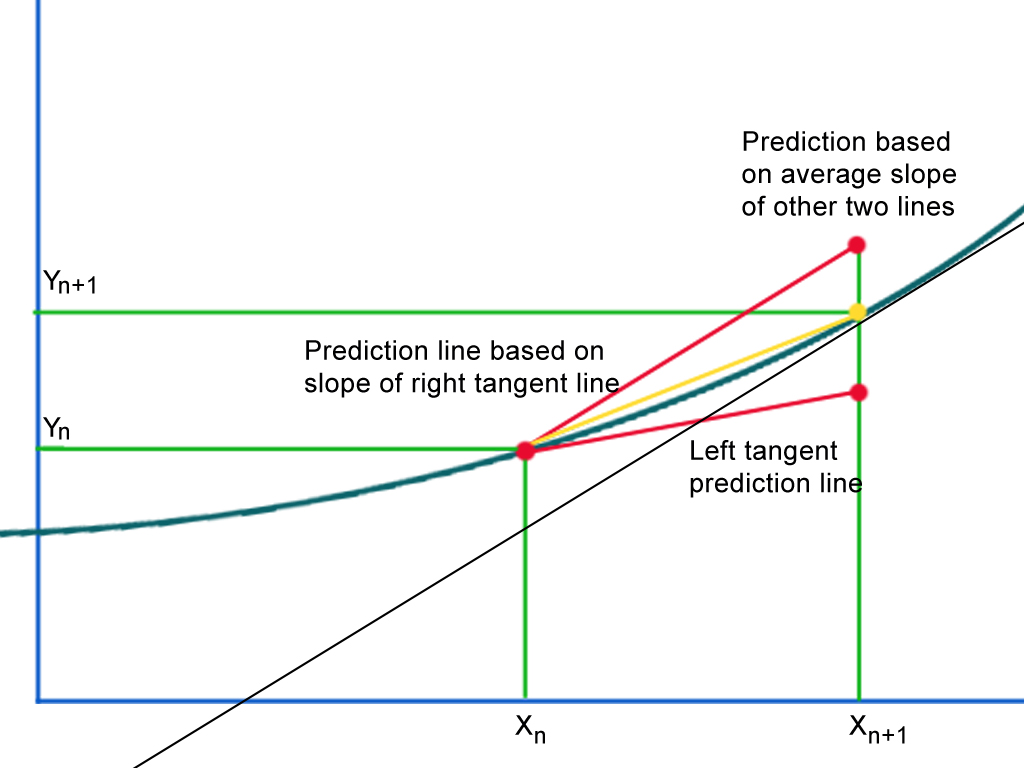

In [9]:
from IPython.display import Image
Image('http://upload.wikimedia.org/wikipedia/commons/5/52/Heun%27s_Method_Diagram.jpg')

In [12]:
heun = ExplicitStateUpdater('''tangent = f(x,t)
                               x_new = x+0.5*dt*(tangent+f(x+dt*tangent, t+dt))''')
print heun(nonlinear_eq)

__tangent_u = a*(b*v - u)
__tangent_v = I - u + 5.0*v + 0.04*v**2.0 + 140.0
_u = 0.5*__tangent_u*dt + 0.5*a*dt*(-__tangent_u*dt + b*(__tangent_v*dt + v) - u) + u
_v = 0.5*__tangent_v*dt + 0.5*dt*(I - __tangent_u*dt + 5.0*__tangent_v*dt - u + 5.0*v + 0.04*(__tangent_v*dt + v)**2.0 + 140.0) + v
u = _u
v = _v


In [13]:
# by directly passing the object, state updaters that Brian doesn't know about can be used
G = NeuronGroup(1, nonlinear_eq, method=heun)

In [14]:
StateUpdateMethod.register('heun', heun)  # register the method
G = NeuronGroup(1, nonlinear_eq, method='heun') # now it can be used like any other method